# Notebook pour créer des statistiques simples sur un corpus CONLL (IOB)

Version : python 3.7

Dernière MAJ : 22/10/2021

Auteur : Lucas Terriel

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from nltk.tree import Tree
from nltk.chunk import conlltags2tree

### 1. charger le fichier CONLL (format IOB)

*N.B : les fichiers CONLL ont été rassemblés au sein d'un unique fichier à l'aide de la commande `$ cat *.conll >> all.conll` (a ne pas lancer si utilisation du notebook conll2samples.ipynb)* 

In [2]:
# Indiquer le chemin vers le fichier
file_path = "./EAD_release/v1_n4a/conll/curated_v1_n4a_all.conll"
filename = os.path.basename(file_path)
with open(file_path, "r", encoding="utf-8") as f:
    conll = f.read()

### 2. Récupération du nombre phrases, de phrases annotées et création des listes de tokens, de tokens annotés et des tags

In [3]:
sentences = 1
sentences_annotated = 1
tokens = []
tags = []
tokens_tagged = []
# Liste intermediare pour tester si la phrases contient des mentions annotées.
inter_sentences_annotated = []

for row in conll.splitlines():
    # si méthode n°1 : sep = "\t"
    # si méthode n°2 : sep = " "
    pair = row.split("\t")
    # Si utilisation de la méthode n°2 :
    # Si la longueur de la liste est égale à 1, cela signifie 
    # que l'on passe à une nouvelle phrase. 
    # if len(pair) == 1:
    # Si utilisation de la méthode n°1 : 
    if pair[0] == "" and pair[1] == "":
        sentences += 1
        if len(inter_sentences_annotated) > 0:
            sentences_annotated += 1
            inter_sentences_annotated = []
        else:
            inter_sentences_annotated = []
    else:
        mention = pair[0]
        ner_tag = pair[1]
        tokens.append(mention)
        tags.append(ner_tag)
        if ner_tag != "O":
            inter_sentences_annotated.append(ner_tag)
            mention_tagged = mention
            tokens_tagged.append(mention_tagged)

### 3. Création d'une dataframe pour compter le total de labels préfixés avec le schéma IOB

In [4]:
iob_df = pd.DataFrame(tags, columns=['Label'])
iob_df = iob_df.value_counts().to_frame('Total').reset_index()
# Enlever les tags correspondant à "O".
iob_df = iob_df.loc[iob_df.Label.str.len()>2]
# iob_df

### 4. Vérification des listes de tokens et des tags IOB

In [5]:
print(tokens[0:20])
print(tags[0:20])

# sanity check
assert len(tokens) == len(tags), 'length between tokens and tags is not the same.'

['JJ', '/', '/', '226', '/', 'A', '465', 'Vincennes', '.', 'Confirmation', 'des', 'privilèges', 'de', 'la', "villed'Aire", '1', ',', 'au', 'bailliage', "d'"]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANISATION', 'I-ORGANISATION']


### 4. Création d'un arbre NLTK pour reconstruire les entités annotées en IOB en une unique classe

Tutoriel : [Jeril Kuriakose, *BIO / IOB Tagged Text to Original Text*, medium, 2019](https://medium.com/analytics-vidhya/bio-tagged-text-to-original-text-99b05da6664)

In [6]:
# "_" correpond au POS Tags. Par défaut, le CONLL Reader de NLTK accepte trois valeur (Mention, POS, NER Tags)
conlltags = [(token, "_", tg) for token, tg in zip(tokens, tags)]
ne_tree = conlltags2tree(conlltags)

In [7]:
original_text = []
for subtree in ne_tree:
    # On passe les tags "O"
    if type(subtree) == Tree:
        original_label = subtree.label()
        original_string = " ".join([token for token, _ in subtree.leaves()])
        original_text.append((original_string, original_label))
        
#print(original_text[0:10])

### 5. Création d'une dataframe pour compter le total de labels groupés

In [8]:
df_entities = pd.DataFrame(original_text, columns=['Mention', 'Label'])
df_sum_labels = df_entities['Label'].value_counts().to_frame('Total').reset_index()
df_sum_labels.rename(columns = {'index':'Label'}, inplace = True)
total_entities = df_sum_labels['Total'].sum()

# sanity check
assert total_entities == len(original_text)

### 6. Exposition de l'ensemble des résultats

Statisques générales sur le corpus : curated_v1_n4a_all.conll 
|- Nombre total de phrases : 106421
|- Nombre total de tokens : 1420050
|- Nombre total de phrases annotées : 872
|- Nombre total de tokens annotés (IOB) : 5522
|- Nombre total de tokens annotés (merge IOB) : 2241
|- nombre total d'entités (merge IOB) : 2241


Nombre de tokens par classes IOB 
 
 
   
 Label 
 Total 
 
 
 
 
 1 
 I-ORGANISATION 
 1206 
 
 
 2 
 B-LOCATION 
 796 
 
 
 3 
 I-TITLE 
 723 
 
 
 4 
 I-PERSON 
 701 
 
 
 5 
 I-LOCATION 
 589 
 
 
 6 
 B-PERSON 
 495 
 
 
 7 
 B-ORGANISATION 
 490 
 
 
 8 
 B-TITLE 
 431 
 
 
 9 
 I-EVENT 
 64 
 
 
 10 
 B-EVENT 
 27 
 
 
 

 
 Nombre d'entités par classes regroupées 
 
 
   
 Label 
 Total 
 
 
 
 
 0 
 LOCATION 
 797 
 
 
 1 
 PERSON 
 495 
 
 
 2 
 ORGANISATION 
 490 
 
 
 3 
 TITLE 
 431 
 
 
 4 
 EVENT 
 28

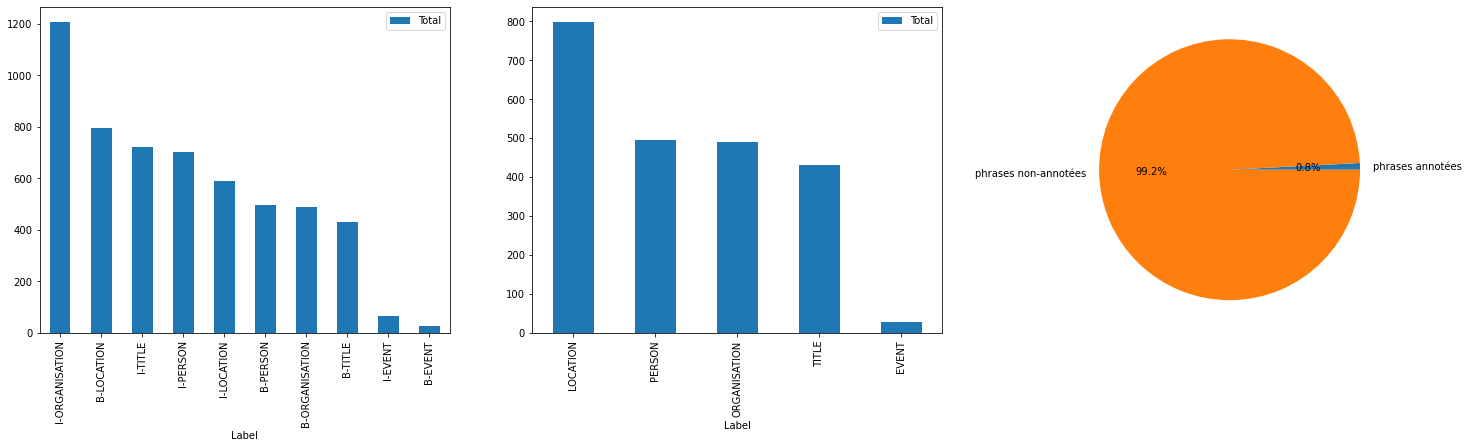

In [9]:
from IPython.display import display_html 

print(f"Statisques générales sur le corpus : {filename} ")
print(f"|- Nombre total de phrases : {sentences}")
print(f"|- Nombre total de tokens : {len(tokens)}")
print(f"|- Nombre total de phrases annotées : {sentences_annotated}")
print(f"|- Nombre total de tokens annotés (IOB) : {len(tokens_tagged)}")
print(f"|- Nombre total de tokens annotés (merge IOB) : {len(original_text)}")
print(f"|- nombre total d'entités (merge IOB) : {len(original_text)}")



# Création des containeurs pour les dataframe
df1_styler = iob_df.style.set_table_attributes("style='display:inline'").set_caption("Nombre de tokens par classes IOB")
df2_styler = df_sum_labels.style.set_table_attributes("style='display:inline'").set_caption("Nombre d'entités par classes regroupées")


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,6))
# Création des diagrammes en barres pour les labels
df1_plot = iob_df.plot(kind='bar', x='Label', y='Total', ax=ax1)
df2_plot = df_sum_labels.plot(kind='bar', x='Label', y='Total', ax=ax2)

# Création du diagramme circulaire pour les phrases
percentage_annotated_sentences = sentences_annotated / sentences * 100
percentage_non_annotated_sentences = (sentences - sentences_annotated) / sentences * 100
sentences_values = [percentage_annotated_sentences, percentage_non_annotated_sentences]
sentences_labels = ['phrases annotées', 'phrases non-annotées']
pie3 = ax3.pie(sentences_values,labels=sentences_labels, autopct='%1.1f%%')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
plt.show()